# Predykcja cen akcji spółki Microsoft z wykorzystaniem LSTM (ang. Long Short-Term Memory)

## Niezbędne biblioteki

In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import *
from keras.api.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import math

In [204]:
import tensorflow as tf

# Enable eager execution
tf.data.experimental.enable_debug_mode()

In [205]:
tf.executing_eagerly()

True

## Zbieranie danych
 * Zakres dat: od `01-01-2010` do `01-01-2024`
 * Oznaczenie spółki: `MSFT.US`

In [212]:
# Ścieżka do pliku CSV w repozytorium
csv_path = './msft_us_historical_data.csv'

# Sprawdzenie, czy plik istnieje
if not os.path.exists(csv_path):
    # URL do pobrania danych historycznych dla MSFT.US
    url = 'https://stooq.com/q/d/l/?s=msft.us&i=d&d1=20100101&d2=20240101'
    
    # Pobieranie danych
    response = requests.get(url)
    
    # Sprawdzenie, czy żądanie się powiodło
    if response.status_code == 200:
        # Zapisanie danych do pliku CSV w repozytorium
        with open(csv_path, 'wb') as file:
            file.write(response.content)
        
        print(f'Dane zostały pobrane i zapisane do {csv_path}')
    else:
        print(f'Błąd podczas pobierania danych: {response.status_code}')
else:
    print(f'Plik {csv_path} już istnieje')

# Wczytanie danych do DataFrame
df = pd.read_csv(csv_path)

# Wyświetlenie pierwszych kilku wierszy
print(df.head())

# Wyświetlenie podstawowych informacji o danych
print(df.info())

# Zmiana typu kolumny 'Date' na typ daty
df['Date'] = pd.to_datetime(df['Date'])

Plik ./msft_us_historical_data.csv już istnieje
         Date     Open     High      Low    Close        Volume
0  2010-01-04  24.0854  24.4389  24.0358  24.3178  4.886916e+07
1  2010-01-05  24.2542  24.4389  24.0765  24.3267  6.331174e+07
2  2010-01-06  24.2642  24.4230  23.9852  24.1758  7.403254e+07
3  2010-01-07  24.0537  24.1232  23.7221  23.9257  6.434577e+07
4  2010-01-08  23.7837  24.2642  23.7608  24.0934  6.515561e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3522 non-null   object 
 1   Open    3522 non-null   float64
 2   High    3522 non-null   float64
 3   Low     3522 non-null   float64
 4   Close   3522 non-null   float64
 5   Volume  3522 non-null   float64
dtypes: float64(5), object(1)
memory usage: 165.2+ KB
None


## Przygotowanie danych

In [213]:
# Wybór kolumny 'Close' do predykcji
data = df['Close'].values.reshape(-1, 1)

# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tworzenie sekwencji danych
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Podział na zbiór treningowy i testowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

y_temp = data[split + seq_length:]

## Funkcja do budowy i trenowania modelu

In [34]:
def build_and_train_model(layers=3, neurons=20, optimizer_class=Adam, optimizer_params={'learning_rate': 0.001}, activation='linear', epochs=50, batch_size=16):
    # Tworzenie modelu sekwencyjnego
    model = Sequential()

    # Dodawanie warstw LSTM
    for i in range(layers):
        if i == 0:
            # Pierwsza warstwa LSTM z określonymi neuronami i kształtem wejściowym
            model.add(Input(shape=(seq_length, 1)))
        elif i == layers - 1:
            # Ostatnia warstwa LSTM bez zwracania sekwencji
            model.add(LSTM(neurons))
        else:
            # Środkowe warstwy LSTM zwracające sekwencje
            model.add(LSTM(neurons, return_sequences=True))
    # Dodawanie warstwy wyjściowej Dense        
    model.add(Dense(1, activation=activation))
    
    # Kompilacja modelu z określonym optymalizatorem i funkcją straty
    optimizer = optimizer_class(**optimizer_params)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Trenowanie modelu na danych treningowych z walidacją na danych testowych
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
    # Zwracanie wytrenowanego modelu i historii trenowania
    return model, history

## Funkcja do rysowania wykresów

In [35]:
def plot_results(df, data, test_data, predicted_data, title, history, file_name, folder_name):
    # Tworzenie folderu, jeśli nie istnieje
    folder_name = 'plots/' + folder_name
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Tworzenie wykresu z trzema podwykresami
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15))

    # Wykres podstawowego zbioru danych do momentu prognozowania
    ax1.plot(df['Date'][:split + seq_length], data[:split + seq_length], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)

    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length:], predicted_data[split + seq_length:], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    # Wykres błędów trenowania i walidacji
    ax3.plot(history.history['loss'], label='Błąd trenowania')
    ax3.plot(history.history['val_loss'], label='Błąd walidacji')
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel('Błąd')
    ax3.set_title('Błąd trenowania i walidacji')
    ax3.legend()
    ax3.grid(True)

    # Zapisywanie wykresu do pliku
    plot_path = os.path.join(folder_name, f'{file_name}.png')
    plt.savefig(plot_path)
    plt.close(fig)

## Określenie parametrów do testów

### Parametry do przetestowania

In [36]:
layers_options = [2, 3, 4, 5]
neurons_options = [50, 100, 150, 200]
optimizers_options = [Adam, RMSprop, SGD, Adagrad]
activations_options = ['tanh', 'sigmoid', 'linear', 'relu']
batch_sizes = [16, 32, 64, 128]

# Przechowywanie wyników
results = []

# Liczba powtórzeń dla każdego zestawu parametrów
num_repeats = 5

### Testowanie wpływu liczby warstw

In [39]:
for layers in layers_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_layers, history_layers = build_and_train_model(layers=layers, optimizer_class=RMSprop, optimizer_params=optimizer_params)
        loss_layers = history_layers.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_layers = model_layers.predict(X_test)
        predicted_layers = scaler.inverse_transform(predicted_layers.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_layers = np.sqrt(mean_squared_error(y_temp, predicted_layers))
        r2_layers = r2_score(y_temp, predicted_layers)

        results.append(('layers', layers, loss_layers, rmse_layers, r2_layers))

        # Przygotowanie danych do wykresu
        predicted_data_layers = np.empty_like(data)
        predicted_data_layers[:, :] = np.nan
        predicted_data_layers[split + seq_length:] = predicted_layers
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_layers, f'Liczba warstw: {layers}', history_layers, f'layers_{layers}_rep_{i}', 'layers')

with pd.ExcelWriter('results.xlsx') as writer:
    df = pd.DataFrame(results, columns=['param', 'value', 'loss', 'rmse', 'R2'])
    df.to_excel(writer, index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


### Testowanie wpływu liczby neuronów

In [42]:
results.clear()

for neurons in neurons_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_neurons, history_neurons = build_and_train_model(neurons=neurons, optimizer_class=RMSprop, optimizer_params=optimizer_params)
        loss_neurons = history_neurons.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_neurons = model_neurons.predict(X_test)
        predicted_neurons = scaler.inverse_transform(predicted_neurons.reshape(-1, 1))

        # Oblicz RMSE i R²
        rmse_neurons = np.sqrt(mean_squared_error(y_temp, predicted_neurons))
        r2_neurons = r2_score(y_temp, predicted_neurons)
        results.append(('neurons', neurons, loss_neurons, rmse_neurons, r2_neurons))
        
        # Przygotowanie danych do wykresu
        predicted_data_neurons = np.empty_like(data)
        predicted_data_neurons[:, :] = np.nan
        predicted_data_neurons[split + seq_length:] = predicted_neurons
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_neurons, f'Liczba neuronów: {neurons}_{i}', history_neurons, f'neurons_{neurons}_rep_{i}', 'neurons')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='neurons', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


### Testowanie wpływu optymalizatora

In [43]:
results.clear()

for optimizer in optimizers_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_optimizer, history_optimizer = build_and_train_model(optimizer_class=optimizer, optimizer_params=optimizer_params)
        loss_optimizer = history_optimizer.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_optimizer = model_optimizer.predict(X_test)
        predicted_optimizer = scaler.inverse_transform(predicted_optimizer.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_optimizer = np.sqrt(mean_squared_error(y_temp, predicted_optimizer))   
        r2_optimizer = r2_score(y_temp, predicted_optimizer)
        results.append(('optimizer', optimizer.__name__, loss_optimizer, rmse_optimizer, r2_optimizer))

        # Przygotowanie danych do wykresu
        predicted_data_optimizer = np.empty_like(data)
        predicted_data_optimizer[:, :] = np.nan
        predicted_data_optimizer[split + seq_length:] = predicted_optimizer
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_optimizer, f'Optymalizator: {optimizer.__name__}_{i}', history_optimizer, f'optimizer_{optimizer.__name__}_rep_{i}', 'optimizer')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='optimizer', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


### Testowanie wpływu funkcji aktywacji

In [44]:
results.clear()

for activation in activations_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_activation, history_activation = build_and_train_model(optimizer_class=RMSprop, optimizer_params=optimizer_params, activation=activation)
        loss_activation = history_activation.history['val_loss'][-1]

        # Predykcja na zbiorze testowym
        predicted_activation = model_activation.predict(X_test)
        predicted_activation = scaler.inverse_transform(predicted_activation.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_activation = np.sqrt(mean_squared_error(y_temp, predicted_activation))
        r2_activation = r2_score(y_temp, predicted_activation)
        results.append(('activation', activation, loss_activation, rmse_activation, r2_activation))

        # Przygotowanie danych do wykresu
        predicted_data_activation = np.empty_like(data)
        predicted_data_activation[:, :] = np.nan
        predicted_data_activation[split + seq_length:] = predicted_activation
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_activation, f'Funkcja aktywacji: {activation}_{i}', history_activation, f'activation_{activation}_rep_{i}', 'activation')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='activation', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


### Testowanie wpływu wielkości batch size

In [45]:
results.clear()

for batch_size in batch_sizes:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_batch_size, history_batch_size = build_and_train_model(optimizer_class=RMSprop, optimizer_params=optimizer_params, batch_size=batch_size)
        loss_batch_size = history_batch_size.history['val_loss'][-1]

        # Predykcja na zbiorze testowym
        predicted_batch_size = model_batch_size.predict(X_test)
        predicted_batch_size = scaler.inverse_transform(predicted_batch_size.reshape(-1, 1))

        # Oblicz RMSE i R²
        rmse_batch_size = np.sqrt(mean_squared_error(y_temp, predicted_batch_size))
        r2_batch_size = r2_score(y_temp, predicted_batch_size)
        results.append(('batch_size', batch_size, loss_batch_size, rmse_batch_size, r2_batch_size))

        # Przygotowanie danych do wykresu
        predicted_data_batch_size = np.empty_like(data)
        predicted_data_batch_size[:, :] = np.nan
        predicted_data_batch_size[split + seq_length:] = predicted_batch_size

        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_batch_size, f'Batch size: {batch_size}_{i}', history_batch_size, f'batch_size_{batch_size}_rep_{i}', 'batch_size')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='batch_size', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


### Model regresji liniowej

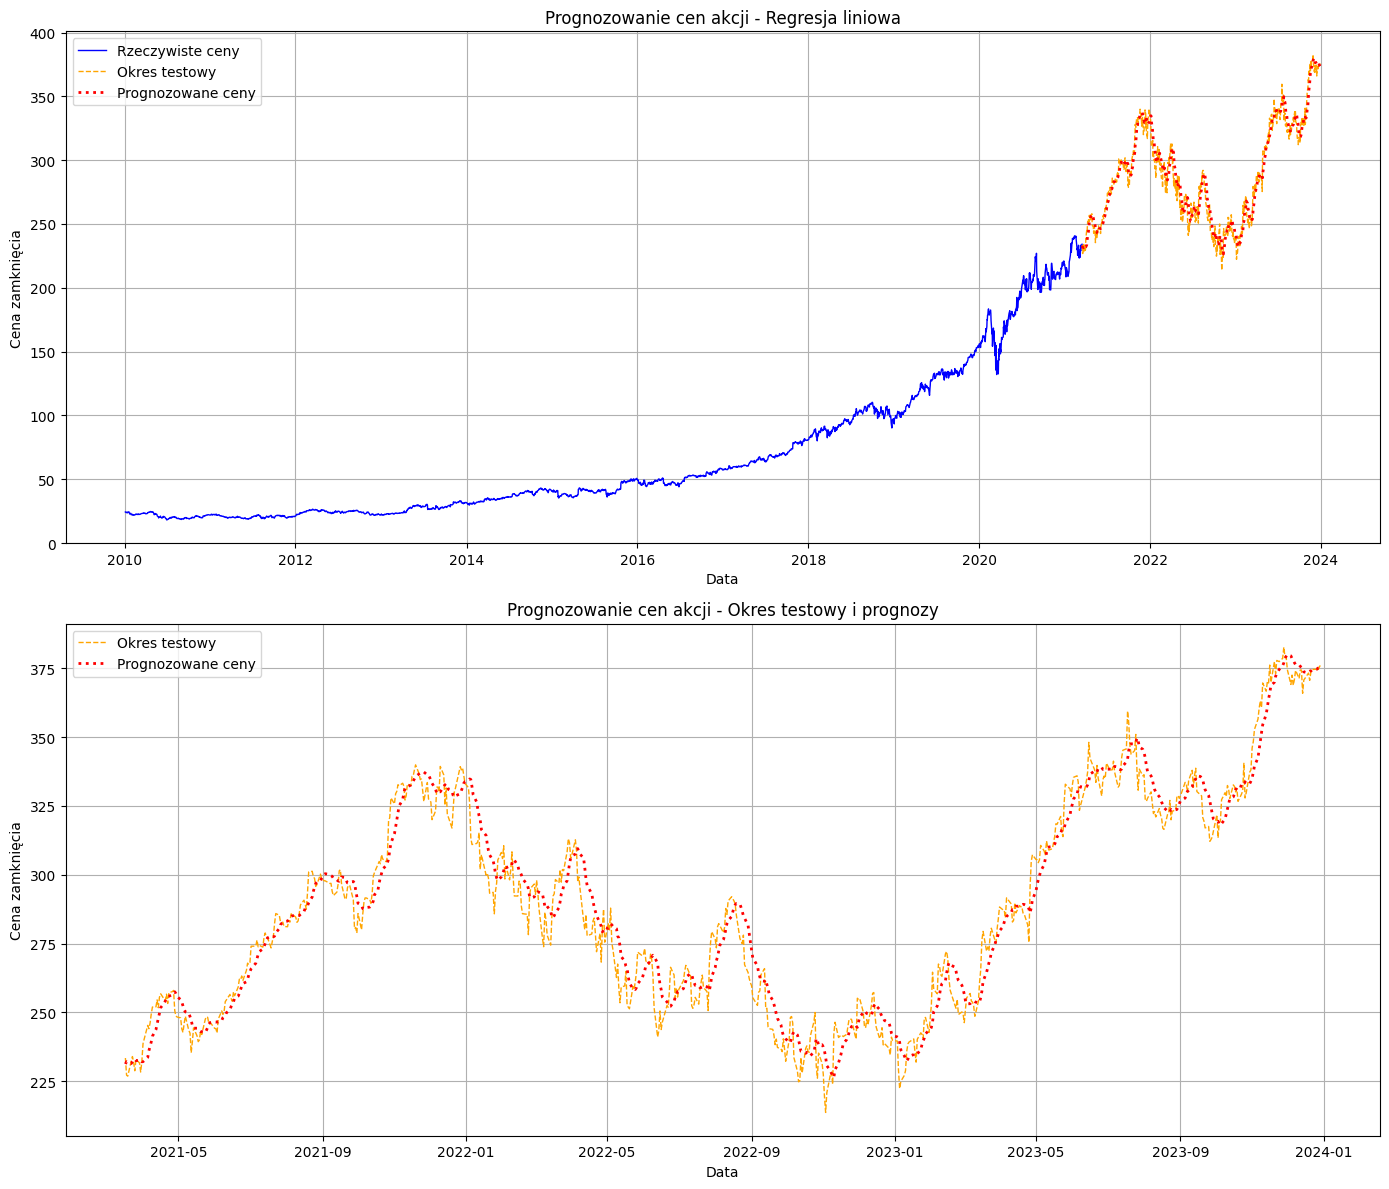

Wartości błędów:
MSE: 61.94225188332305
RMSE: 7.870340010655388
R²: 0.9592146898383271



In [208]:
# Implementacja modelu regresji liniowej
class LinearRegression:

        def __init__(self, learning_rate = 0.001, num_iterations = 1000):
            self.learning_rate = learning_rate
            self.num_iterations = num_iterations
            self.weights = None
            self.bias = None

        # Funkcja do trenowania modelu regresji liniowej
        def fit(self, X, y):
            n_samples, n_features = X.shape
            self.weights = np.zeros((n_features, 1))  # Zmieniono na (n_features, 1)
            self.bias = 0

            y = y.reshape(-1, 1)  # Upewniamy się, że y ma wymiar (n_samples, 1)

            for _ in range(self.num_iterations):
                y_predicted = np.dot(X, self.weights) + self.bias  # (n_samples, 1)

                d_w = (2/n_samples) * np.dot(X.T, (y_predicted - y))  # (n_features, 1)
                d_b = (2/n_samples) * np.sum(y_predicted - y)  # Scalar

                self.weights -= self.learning_rate * d_w
                self.bias -= self.learning_rate * d_b

        

        # Funkcja do predykcji modelu
        def predict(self, X):
            y_predicted = np.dot(X, self.weights) + self.bias
            return y_predicted

# Przygotowanie danych
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Uczenie modelu
reg = LinearRegression(learning_rate=0.01, num_iterations=100000)
reg.fit(X_train, y_train)

# Predykcja
predictions = reg.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Funkcja do obliczania błędów
def calculate_errors(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = math.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, rmse, r2

def plot_results_linear(df, data, test_data, predicted_data, title):
    
    predicted_data = predicted_data.flatten()
    test_data = test_data.flatten()

    # Tworzenie wykresu z dwoma podwykresami
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Wykres podstawowego zbioru danych do momentu prognozowania
    ax1.plot(df['Date'][:split + seq_length], data[:split + seq_length], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji - {title}')
    ax1.legend()
    ax1.grid(True)

    # Szczegóły dla okresu testowego
    ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length:], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Obliczanie błędów prognozowania
    mse, rmse, r2 = calculate_errors(original_y_test, predictions)
    print(f'Wartości błędów:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R²: {r2}\n')

plot_results_linear(df, data, original_y_test, predicted_data=predictions, title='Regresja liniowa')

### Model ARIMA

Augmented Dickey-Fuller Test:
ADF Test Statistic: -21.020290022861907
p-value: 0.0
Number of Lags Used: 8
Number of Observations Used: 3512
Dane są stacjonarne.


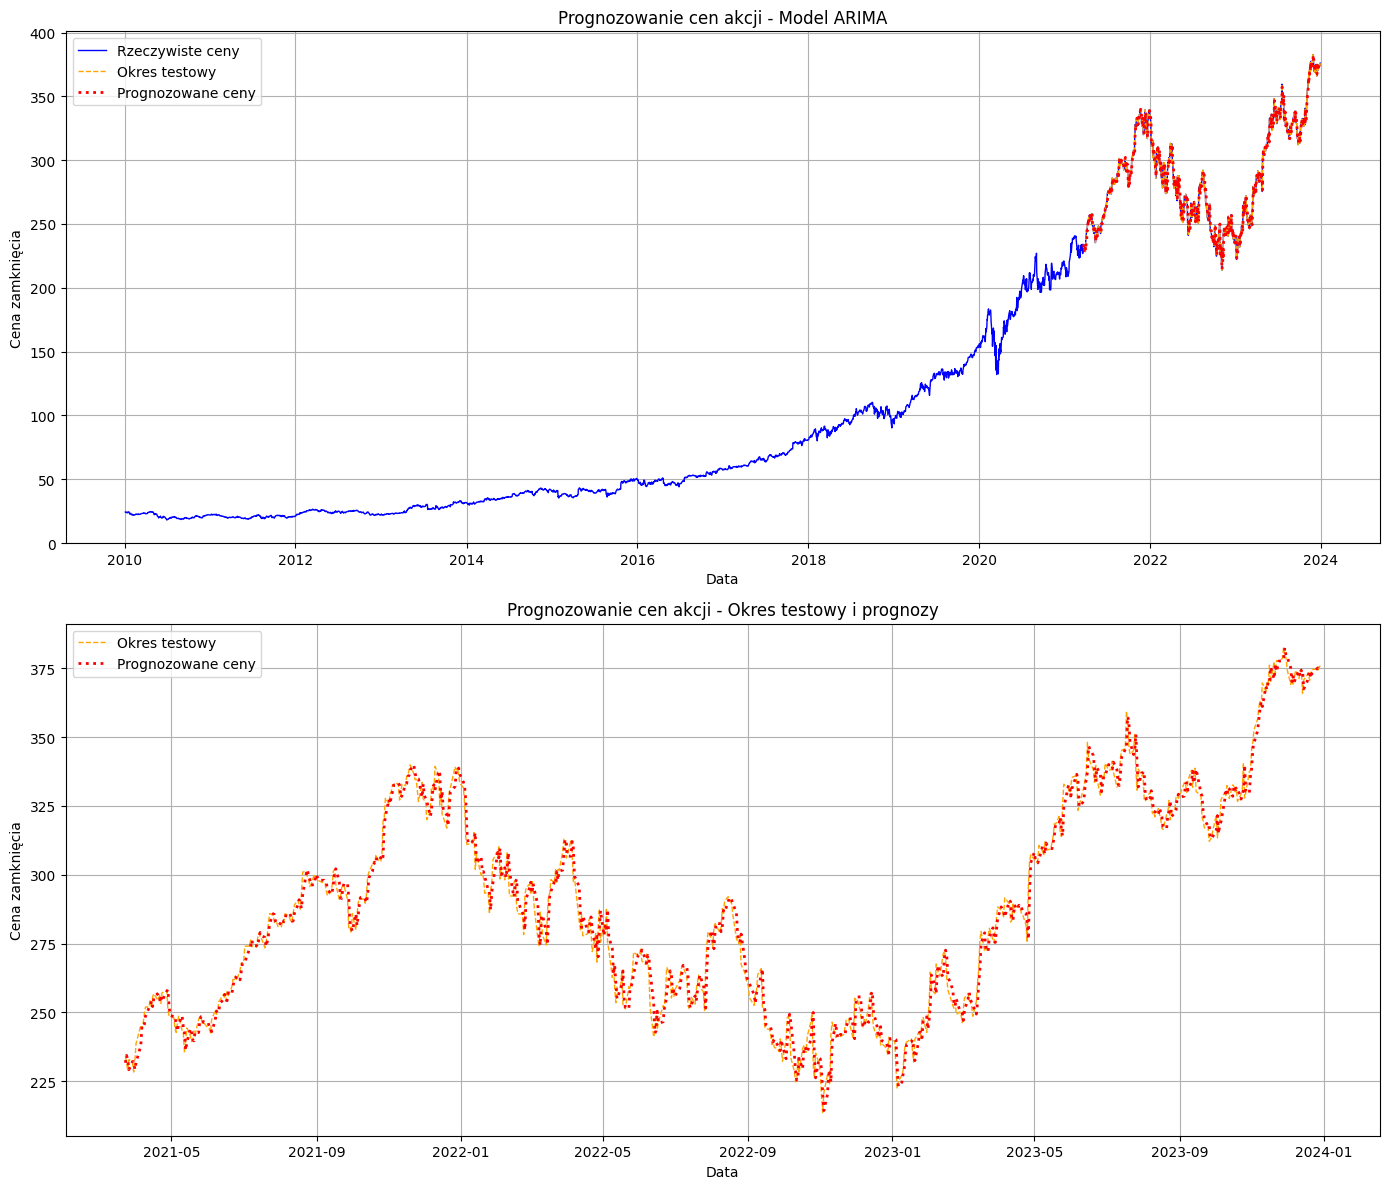

Wartości błędów:
MSE: 24.888851731649517
RMSE: 4.988872791688471
R²: 0.9834908273838441



In [214]:
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Logarytmiczne różnicowanie danych
df['Log_Close'] = np.log(df['Close'])
df['Diff_Close'] = df['Log_Close'].diff()

def adf_check(time_series):
    result = adfuller(time_series.dropna()) 
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used']
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')
    print("Dane są stacjonarne." if result[1] <= 0.05 else "Dane nie są stacjonarne.\n")

# Sprawdzenie stacjonarności danych po różnicowaniu
adf_check(df['Diff_Close'])

def AR(p, df):
    df_temp = df[['Diff_Close']].copy()

    # Tworzenie zmiennych opóźnionych
    for i in range(1, p + 1):
        df_temp[f'Shifted_{i}'] = df_temp['Diff_Close'].shift(i)
    
    # Podział na zbiór treningowy i testowy
    train_size = int(0.8 * len(df_temp))
    df_train = df_temp.iloc[:train_size].dropna()
    df_test = df_temp.iloc[train_size:]

    X_train = df_train.iloc[:, 1:].values
    y_train = df_train.iloc[:, 0].values.reshape(-1, 1)

    # Trenowanie modelu regresji liniowej
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)

    df_train['Predicted_Close'] = linear_reg.predict(X_train)
    df_test['Predicted_Close'] = df_test.iloc[:, 1:].dot(linear_reg.coef_.T) + linear_reg.intercept_

    return df_train, df_test, linear_reg.coef_.T, linear_reg.intercept_

# Wybór najlepszego parametru p
best_p = 5
df_train, df_test, coefficients, intercept = AR(best_p, df)
df_c = pd.concat([df_train, df_test])

# Obliczanie reszt
df_c['Residuals'] = df_c['Diff_Close'] - df_c['Predicted_Close']

def MA(q, res):
    res_temp = res[['Residuals']].copy()

    # Tworzenie zmiennych opóźnionych dla reszt
    for i in range(1, q + 1):
        res_temp[f'Shifted_Residuals_{i}'] = res_temp['Residuals'].shift(i)
    
    # Podział na zbiór treningowy i testowy
    train_size = int(0.8 * len(res_temp))
    res_train = res_temp.iloc[:train_size].dropna()
    res_test = res_temp.iloc[train_size:]

    X_train = res_train.iloc[:, 1:].values
    y_train = res_train.iloc[:, 0].values.reshape(-1, 1)

    # Trenowanie modelu regresji
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)

    res_train['Predicted_Close'] = linear_reg.predict(X_train)
    res_test['Predicted_Close'] = res_test.iloc[:, 1:].dot(linear_reg.coef_.T) + linear_reg.intercept_

    return res_train, res_test, linear_reg.coef_.T, linear_reg.intercept_

best_q = 5
res_train, res_test, coefficients, intercept = MA(best_q, df_c)

res_c = pd.concat([res_train, res_test])
df_c['Predicted_Close'] += res_c['Predicted_Close']

# Powrót do oryginalnej skali
df_c['Predicted_Close'] = np.exp(df_c['Predicted_Close'] + df['Log_Close'].shift(1).fillna(0))
df_c['Actual_Close'] = np.exp(df_c['Diff_Close'] + df['Log_Close'].shift(1).fillna(0))

# Określenie okresu testowego
split = int(0.8 * len(df))
predicted_test = df_c.iloc[split:]['Predicted_Close']
test_actual = df_c.iloc[split:]['Actual_Close']

def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    return mse, rmse, r2

def plot_results_arima(df, test_actual, predicted_test, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    ax1.plot(df.index, df['Close'], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(test_actual.index, test_actual, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(predicted_test.index, predicted_test, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji - {title}')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(test_actual.index, test_actual, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(predicted_test.index, predicted_test, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Obliczanie błędów prognozowania
    mse, rmse, r2 = calculate_errors(test_actual.values, predicted_test.values)
    print(f'Wartości błędów:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R²: {r2}\n')

plot_results_arima(df, test_actual, predicted_test, title='Model ARIMA')

df = df.reset_index()

### Średnia ruchoma (MA)

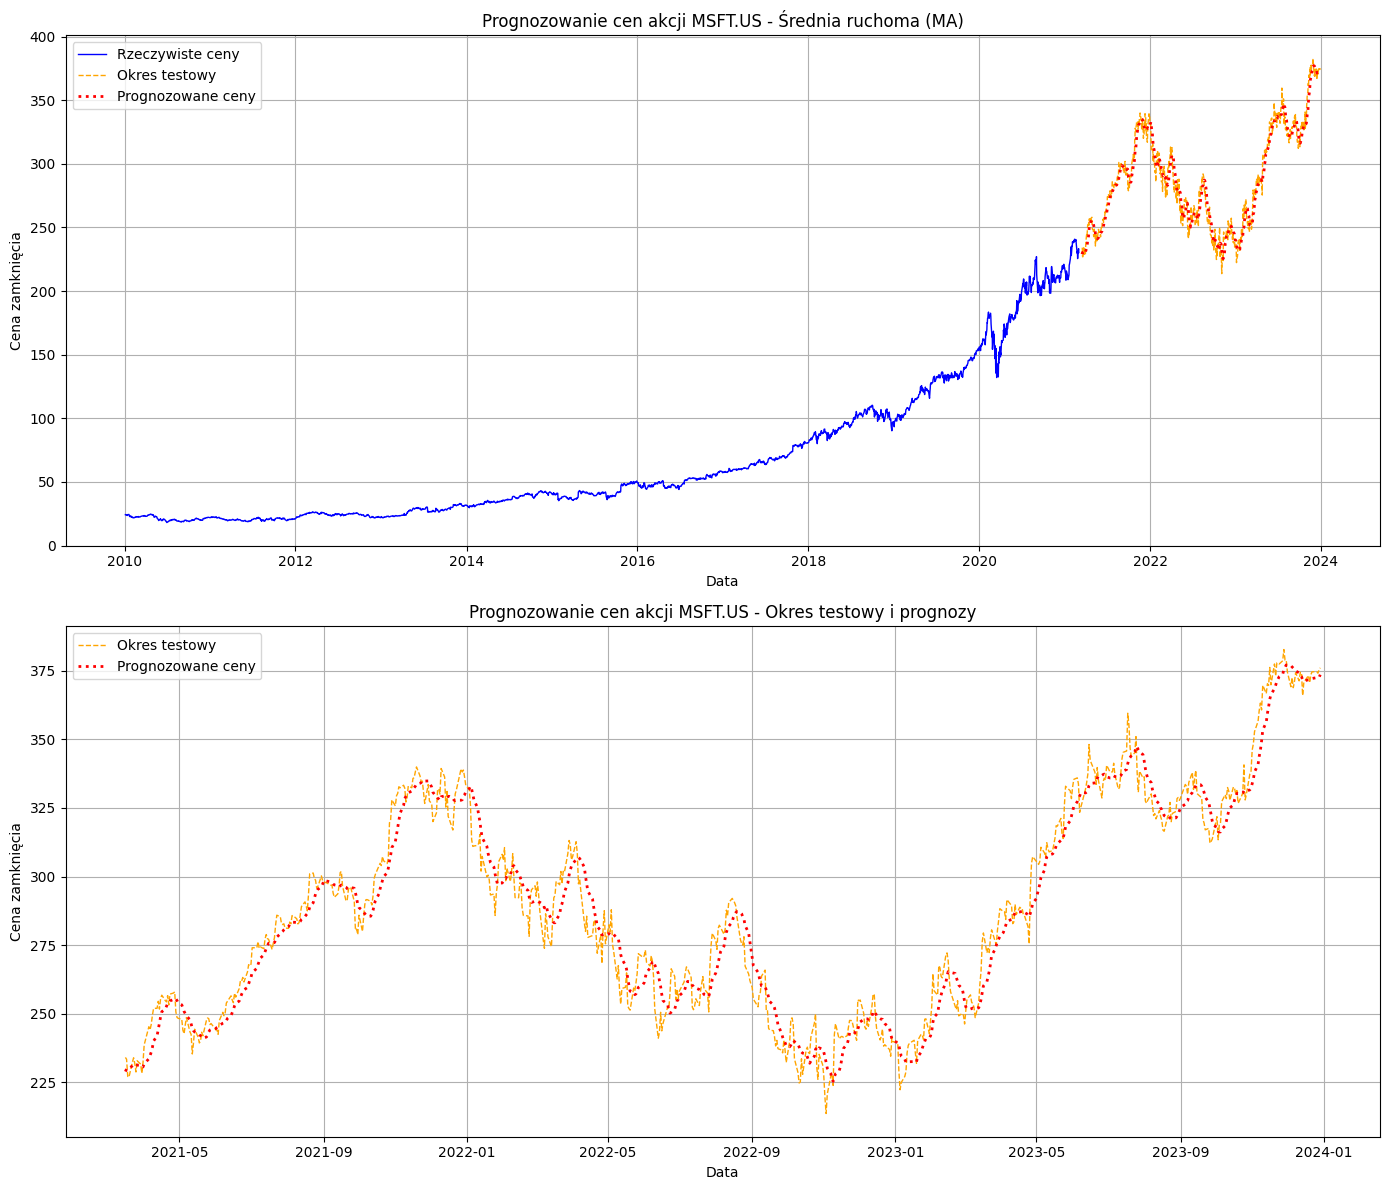

Wartości błędów:
MSE: 58.19876820279831
RMSE: 7.628811716302764
R²: 0.9617315037218807



In [ ]:
# średnia ruchoma (MA)
def moving_average(prices, window):
    ma_values = []
    for i in range(len(prices) - window + 1):
        ma_values.append(np.mean(prices[i:i+window]))
    return np.array(ma_values)

# Obliczenie prognoz
ma_test = moving_average(data[split:], window=seq_length)      

# Funkcja do obliczania błędów
def calculate_errors(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = math.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, rmse, r2

def plot_results_ma(df, data, test_data, predicted_data, title):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Wykres podstawowego zbioru danych do momentu prognozowania
    ax1.plot(df['Date'][:split], data[:split], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length - 1: split + seq_length - 1 + len(test_data[seq_length - 1:])], test_data[seq_length - 1:], color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'][split + seq_length - 1: split + seq_length - 1 + len(predicted_data)], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)
    
    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length - 1: split + seq_length - 1 + len(test_data[seq_length - 1:])], test_data[seq_length - 1:], color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length - 1: split + seq_length - 1 + len(predicted_data)], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    mse, rmse, r2 = calculate_errors(test_data[seq_length - 1:], predicted_data)
    print(f'Wartości błędów:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R²: {r2}\n') 

# Wizualizacja wyników
plot_results_ma(df, data, data[split:], ma_test, title='Średnia ruchoma (MA)')

### Wykładnicza średnia ruchoma (EMA)

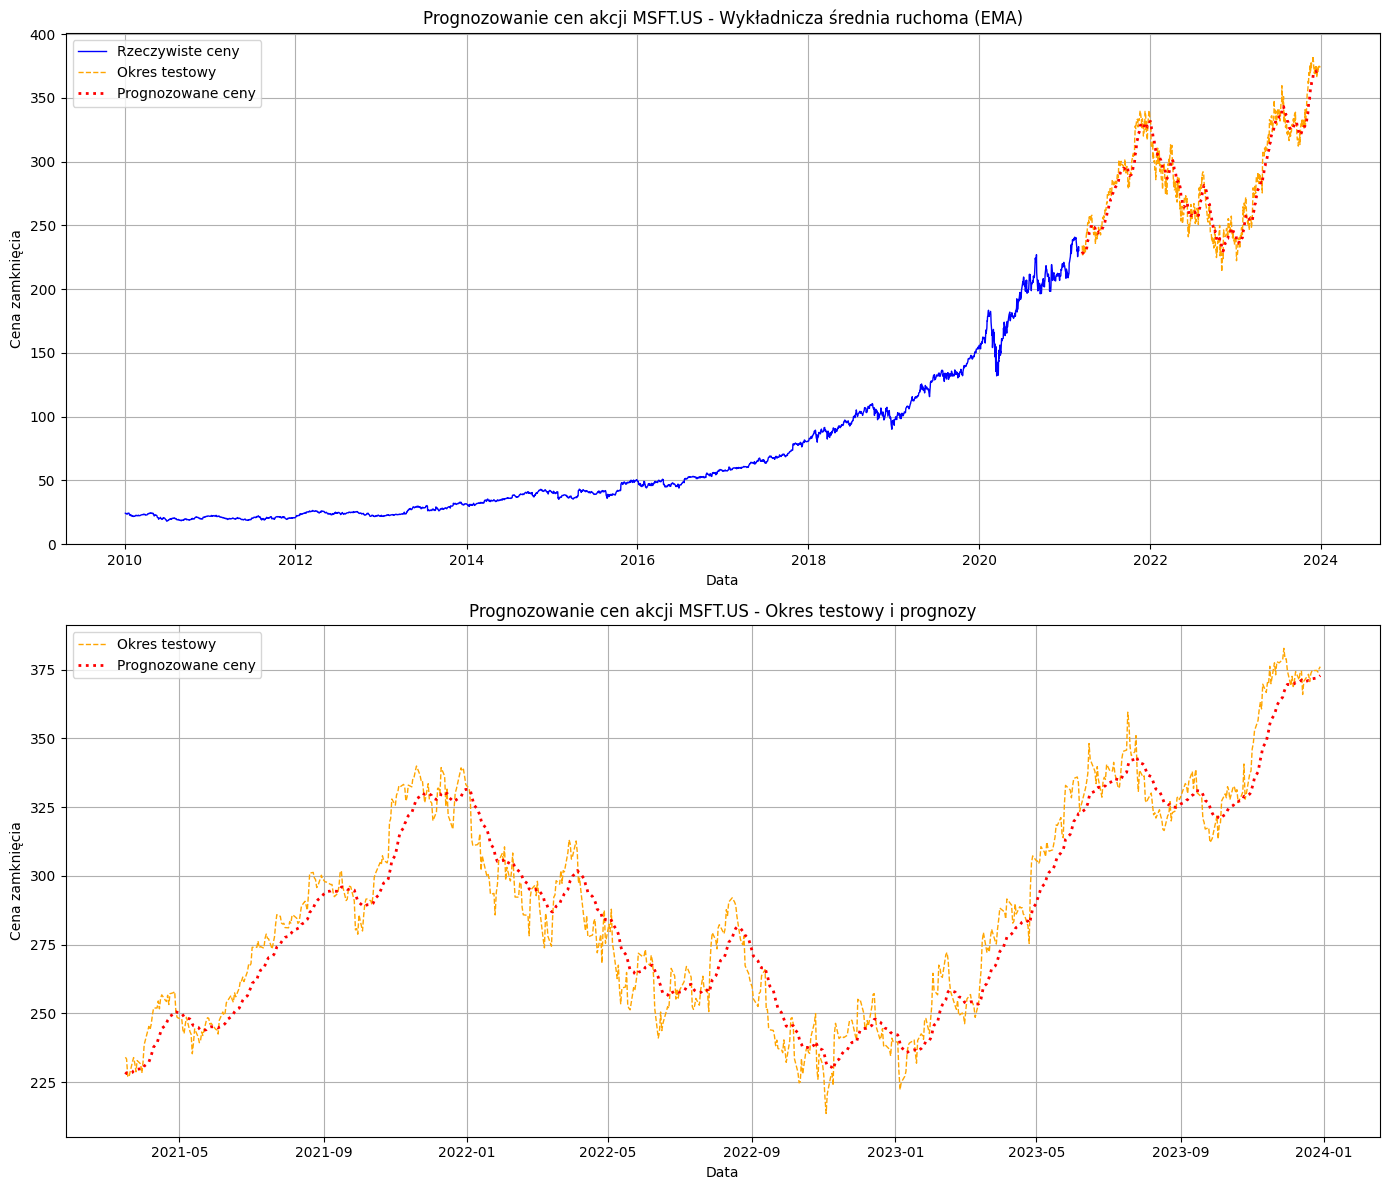

Wartości błędów:
MSE: 85.70992199938314
RMSE: 9.257965327186268
R²: 0.9436415935883402



In [58]:
# wykładnicza średnia ruchoma (EMA)
def exponential_moving_average(prices, alpha=0.1):
    ema_values = [prices[0]]
    for price in prices[1:]:
        ema_values.append(alpha * price + (1 - alpha) * ema_values[-1])
    return np.array(ema_values)

# Obliczenie prognoz
ema_test = exponential_moving_average(data[split:], alpha=0.1)  

def plot_results_ema(df, data, test_data, predicted_test, title):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Wykres podstawowego zbioru danych do momentu prognozowania
    ax1.plot(df['Date'][:split], data[:split], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length - 1:split + seq_length - 1 + len(test_data[seq_length - 1:])], 
             test_data[seq_length - 1:], color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'][split + seq_length - 1:split + seq_length - 1 + len(predicted_test[seq_length - 1:])], 
             predicted_test[seq_length - 1:], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)
    
    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length - 1:split + seq_length - 1 + len(test_data[seq_length - 1:])], 
             test_data[seq_length - 1:], color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length - 1:split + seq_length - 1 + len(predicted_test[seq_length - 1:])], 
             predicted_test[seq_length - 1:], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Obliczanie błędów 
    mse, rmse, r2 = calculate_errors(test_data[seq_length - 1:], predicted_test[seq_length - 1:])
    print(f'Wartości błędów:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R²: {r2}\n')

# Wizualizacja wyników
plot_results_ema(df, data, data[split:], ema_test, title='Wykładnicza średnia ruchoma (EMA)')